In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv
/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv


In [2]:
def has_right_to_left_letters(text):
    """
    Checks if the text contains any letters written in right-to-left (RTL) languages.

    Args:
    text: The text to check.

    Returns:
    True if the text contains any RTL letters, False otherwise.
    """

    # Define a dictionary for RTL script Unicode ranges
    # based on https://www.unicode.org/charts/ and https://en.wikipedia.org/wiki/Right-to-left_script
    # Added Current scripts only
    rtl_ranges = {
      "Arabic": (0x0600, 0x06FF),
      "Hebrew": (0x0590, 0x05FF),
      "Thaana": (0x0780, 0x07BF),
      "Syriac": (0x0700, 0x074F),
      "Mandaic": (0x0840, 0x085F),
      "Samaritan": (0x0800, 0x083F),
      "Mende Kikakui": (0x1E800, 0x1E8DF),
      "NKo": (0x07C0, 0x07FF),
      "Garay": (0x10D40, 0x10D8F),
      "Adlam": (0x1E900, 0x1E95F),
      "Hanifi Rohingya": (0x10D00, 0x10D3F),
      "Yezidi": (0x10E80, 0x10EBF)
  }

    for char in text:
        for script, range in rtl_ranges.items():
            if range[0] <= ord(char) <= range[1]:
                return True
    return False

# Example usage
text_with_arabic = "مرحبا بالعالم!"
text_with_persian = "سلام دنیا!"
text_with_hebrew = " שלום עולם!"
text_with_thaana = "ދިވެހި ބަސް"
text_with_syriac = "ܡܪܝܐ ܝܗܘܒ ܠܟ ܫܠܳܡܳܐ"
text_with_english = "Hello, world!"

# Example usage (unchanged)
print(has_right_to_left_letters(text_with_arabic))  # Output: True
print(has_right_to_left_letters(text_with_persian))  # Output: True
print(has_right_to_left_letters(text_with_hebrew))  # Output: True
print(has_right_to_left_letters(text_with_thaana))  # Output: True
print(has_right_to_left_letters(text_with_syriac))  # Output: True
print(has_right_to_left_letters(text_with_english))  # Output: False

True
True
True
True
True
False


In [3]:
def is_bidi_manipulated(text):
    """
    Checks if a text (assumed to be non-RTL) contains BiDi override characters,
    potentially indicating manipulation.

    Args:
        text: The text to check.

    Returns:
        A tuple containing two elements:
            - is_manipulated (bool): True if BiDi override characters are found, 
                                     False otherwise.
            - override_count (int): The number of BiDi override characters found.
    """

    # Define a set of BiDi override characters
    bidi_overrides = {
        chr(0x202A): "LRE (Left-to-Right Embedding)",
        chr(0x202B): "RLE (Right-to-Left Embedding)",
        chr(0x202C): "PDF (Pop Directional Formatting)",
        chr(0x202D): "LRO (Left-to-Right Override)",
        chr(0x202E): "RLO (Right-to-Left Override)",
        chr(0x2066): "LRI (Left-to-Right Isolate)",
        chr(0x2067): "RLI (Right-to-Left Isolate)",
        chr(0x2069): "PDI (Pop Directional Isolate)"
    }

    # Check if the text is not empty and assumed to be non-RTL
    if not text or has_right_to_left_letters(text):  
        return False, 0

    override_count = 0
    for char in text:
        if char in bidi_overrides:
            override_count += 1

    return override_count > 0, override_count

# Example usage
RLE = chr(0x202B)
RLO = chr(0x202E)

text_with_bidi = "This is normal text with an override " + RLE + "مرحبا بالعالم!" + RLO
text_without_bidi = "This is just normal text"

is_manipulated, count = is_bidi_manipulated(text_with_bidi)
print(f"Text with BiDi override: {text_with_bidi}")
print(f"Is manipulated: {is_manipulated}, Override count: {count}, Other characters { len(text_with_bidi) - count}")

is_manipulated, count = is_bidi_manipulated(text_without_bidi)
print(f"Text without BiDi override: {text_without_bidi}")
print(f"Is manipulated: {is_manipulated}, Override count: {count}, Other characters { len(text_without_bidi) - count}")


Text with BiDi override: This is normal text with an override ‫مرحبا بالعالم!‮
Is manipulated: False, Override count: 0, Other characters 53
Text without BiDi override: This is just normal text
Is manipulated: False, Override count: 0, Other characters 24


In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# Load the dataset
data = pd.read_csv("/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv")

# Initialize empty lists to store results
texts, is_manipulated, override_counts, other_char_counts,is_rtl = [], [], [], [],[]

# Analyze data using tqdm for progress bar
for text in tqdm(data["Reordered Text"]):
    is_manipulated_flag, override_count = is_bidi_manipulated(text)
    other_char_count = len(text) - override_count
    texts.append(text)
    is_manipulated.append(is_manipulated_flag)
    override_counts.append(override_count)
    other_char_counts.append(other_char_count)
    is_rtl.append(has_right_to_left_letters(text))

# Create DataFrame with results
df = pd.DataFrame({
  "Text": texts,
  "Is Manipulated": is_manipulated,
  "Override Count": override_counts,
  "Other Character Count": other_char_counts,
  "Is RTL": is_rtl
})

# Save DataFrame as CSV
df.to_csv("bidi_analysis_results.csv", index=False)

print("Analysis completed! Results saved to bidi_analysis_results.csv")

100%|██████████| 1000/1000 [00:13<00:00, 73.28it/s]


Analysis completed! Results saved to bidi_analysis_results.csv


In [5]:
# Load datasets
data_reordered = pd.read_csv("/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv")
data_clean = pd.read_csv("/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv")

# Filter data_clean for "unwatermarked" label
data_clean = data_clean[data_clean["label"] == "unwatermarked"]

# Select only the desired column
data_reordered = data_reordered[["Reordered Text"]]
data_clean = data_clean[["Generated Text"]]

# Rename column name
data_reordered.rename(columns={"Reordered Text": "text"}, inplace = True)
data_clean.rename(columns={"Generated Text": "text"}, inplace = True)

# Assign label "clean"
data_reordered["label"] = "reordered"
# Assign label "clean"
data_clean["label"] = "clean"
# Combine datasets
data = pd.concat([data_reordered, data_clean], ignore_index=True)

# Initialize empty lists to store results
texts, is_manipulated, override_counts, other_char_counts, is_rtl, labels, actual_labels = [], [], [], [], [], [],[]

# Analyze data using tqdm for progress bar
for text, label in tqdm(zip(data["text"], data["label"]), total=len(data)):
    # Check for RTL language (replace with your is_right_to_left function
    is_manipulated_flag, override_count = is_bidi_manipulated(text)
    other_char_count = len(text) - override_count
    classified_label = "reordered" if is_manipulated_flag else "clean"
    texts.append(text)
    is_manipulated.append(is_manipulated_flag)
    override_counts.append(override_count)
    other_char_counts.append(other_char_count)
    is_rtl.append(has_right_to_left_letters(text))
    actual_labels.append(label)
    labels.append(classified_label)

# Create DataFrame with results
df = pd.DataFrame({
  "Text": texts,
  # Drop label column and replace with "clean" for data_clean
  "label": labels,
  "Actual Label": actual_labels,
  "Is Manipulated": is_manipulated,
  "Override Count": override_counts,
  "Other Character Count": other_char_counts,
  "Is RTL": is_rtl
})

# Save DataFrame as CSV
df.to_csv("bidi_analysis_results.csv", index=False)


100%|██████████| 2000/2000 [00:14<00:00, 140.00it/s] 


In [6]:
# Import libraries for evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import matplotlib.pyplot as plt


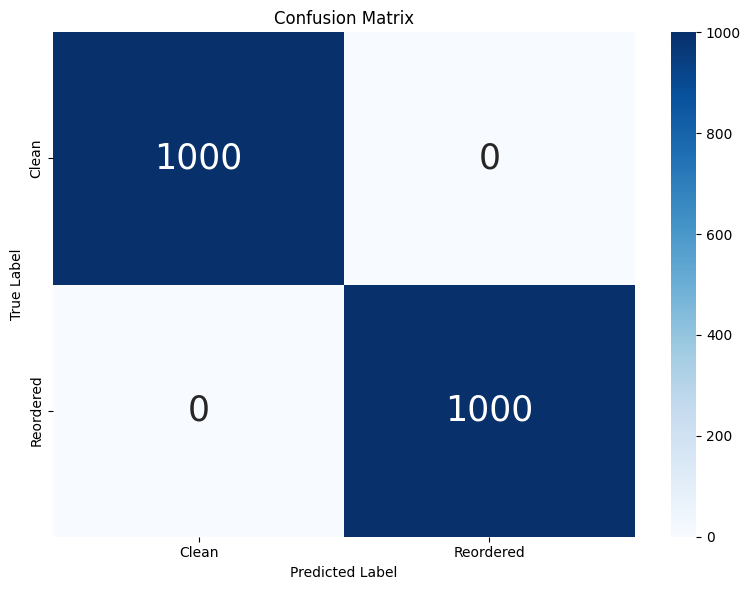


Classification Metrics:
Accuracy: 100.0000
F1-score: 100.0000
Precision: 100.0000
Recall: 100.0000


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['Actual Label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')

    # Define custom labels for the confusion matrix (modify for your labels)
    class_labels = ['Clean', 'Reordered']  # Assuming these are your labels

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    plt.xticks([0.5, 1.5], class_labels)
    plt.yticks([0.5, 1.5], class_labels)  
    plt.tight_layout()
    plt.show()

    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/bidi_analysis_results.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
